In [64]:
import torch, numpy as np, config, os
from PIL import Image, ImageDraw
from loss import _decode_boxes         # already defined in Loss textdoc
from loss import _decode_predictions   # same – decodes + score-threshold

CELL = 896 // config.S                # = 8 px for S = 112

# ----------------------------------------------------------------------
# helpers ---------------------------------------------------------------
# ----------------------------------------------------------------------
# ----------------------------------------------------------
def _rel2abs(cx, cy, w, h):
    cx, cy, w, h = cx*896, cy*896, w*896, h*896
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

def _gt_box_from_row(row):
    cx = (row['cx'] + row['tx']) / config.S
    cy = (row['cy'] + row['ty']) / config.S
    w  = np.exp(row['tw']) * config.ANCHORS[0][0]
    h  = np.exp(row['th']) * config.ANCHORS[0][1]
    return _rel2abs(cx, cy, w, h)

# ----------------------------------------------------------
def render_prediction(model, gt_df, img_id, score_thresh=0.3, device='cuda'):
    """Save & return a 896×896 image with GT (green) and preds (red)."""
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann['filename'].iloc[0])
    pil = Image.open(img_path).convert('RGB').resize((896, 896))

    # forward pass -----------------------------------------------------
    model = model.to(device).eval()
    x = (torch.tensor(np.asarray(pil), dtype=torch.float32)
            .permute(2,0,1).unsqueeze(0).div_(255).to(device))
    with torch.no_grad():
        preds = model(x).cpu()
    det = _decode_predictions(preds, score_thresh)[0]

    # draw -------------------------------------------------------------
    draw = ImageDraw.Draw(pil, 'RGBA')

    # GT green
    for _, row in ann.iterrows():
        draw.rectangle(_gt_box_from_row(row), outline=(0,255,0,200), width=2)

    #predictions red
    for tx, ty, w, h in det['boxes']:
        draw.rectangle(_rel2abs(tx, ty, w, h),
                       outline=(255,0,0,180), width=2)

    out_path = os.path.join(os.path.dirname(os.path.dirname(img_path)), "evaluation", f"{img_id}_viz.png")
    pil.save(out_path)
    print(f"[render_prediction] saved → {out_path}")
    return pil


In [62]:
import os, numpy as np, config
from PIL import Image, ImageDraw

# ------------------------------------------------------------------ constants
SIDE   = 896                      # target size (square)
S      = config.S
ANCHOR = config.ANCHORS[0]        # (w₀, h₀) in relative units

# ------------------------------------------------------------------ helpers
def _rel2abs(cx, cy, w, h):
    """Relative 0-1 centre/size  →  absolute pixel corners (896×896)."""
    cx, cy, w, h = cx*SIDE, cy*SIDE, w*SIDE, h*SIDE
    return [cx - w/2, cy - h/2, cx + w/2, cy + h/2]

def _gt_box_from_row(row):
    """Decode (cx,cy,tx,ty,tw,th) row to absolute pixel rectangle."""
    cx = (row.cx + row.tx) / S
    cy = (row.cy + row.ty) / S
    w  = np.exp(row.tw) * ANCHOR[0]
    h  = np.exp(row.th) * ANCHOR[1]
    return _rel2abs(cx, cy, w, h)

# ------------------------------------------------------------------ main
def render_gt(gt_df, img_id,
              *, colour=(0, 255, 0, 200),
              out_dir="evaluation",
              size=SIDE):
    """
    Draw every GT box for `img_id` on an 896×896 page preview.

    Parameters
    ----------
    gt_df   : dataframe containing at least [img_id,cx,cy,tx,ty,tw,th,filename]
    img_id  : which page to render
    colour  : RGBA outline for GT boxes
    out_dir : folder where PNG is saved
    size    : output resolution (square). 896 keeps parity with training.

    Returns
    -------
    PIL.Image.Image  – the rendered picture
    """
    ann = gt_df[gt_df.img_id == img_id]
    if ann.empty:
        raise ValueError(f"no rows with img_id={img_id}")

    img_path = os.path.join(config.img_dir, ann.filename.iloc[0])
    pil = Image.open(img_path).convert("RGB").resize((size, size))

    draw = ImageDraw.Draw(pil, "RGBA")
    for _, row in ann.iterrows():
        draw.rectangle(_gt_box_from_row(row), outline=colour, width=2)

    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_gt_only.png")
    pil.save(out_path)
    print(f"[render_gt] saved → {out_path}")
    return pil


In [79]:
import util
import model as m

de = util.DataExtractor()
anns = de.normalizedData()
img_ids = anns["img_id"].unique().tolist()


Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [101]:
import json
data = de.loadData()

In [ ]:
##Generate a filtered very lightweight training json
import json
import pathlib

# ------------------------------------------------------------------
# Paths
in_path  = pathlib.Path(config.filepath)          # original file
out_path = in_path.with_stem(in_path.stem + "_slim")  # e.g. deepscores_train_filtered.json
# ------------------------------------------------------------------

# 1) load the full dataset
with in_path.open("r", encoding="utf-8") as f:
    data = json.load(f)

# 2) collect annotation IDs actually used by the 11 images
used_ids = {ann_id for img in data["images"] for ann_id in img["ann_ids"]}

# 3) build a pared-down annotations dict (only a_bbox, cat_id, img_id)
keep_keys = {"a_bbox", "cat_id", "img_id"}
data["annotations"] = {
    ann_id: {k: v for k, v in ann.items() if k in keep_keys}
    for ann_id, ann in data["annotations"].items()
    if ann_id in used_ids
}

print(f"kept {len(data['annotations'])} annotations; "
      f"each with keys {sorted(keep_keys)}")

# 4) save compact JSON (no pretty-printing)
with out_path.open("w", encoding="utf-8") as f:
    json.dump(data, f, separators=(",", ":"))

print(f"filtered file written →  {out_path}")


kept 6195 annotations; each with keys ['a_bbox', 'cat_id', 'img_id']
filtered file written →  c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\deepscores_train_filtered.json


In [117]:
print(counter)
print(len(annotation_ids))
print(annotation_ids)

11
6195
['1113019', '1113020', '1113021', '1113022', '1113023', '1113024', '1113025', '1113026', '1113027', '1113028', '1113029', '1113030', '1113031', '1113032', '1113033', '1113034', '1113035', '1113036', '1113037', '1113038', '1113039', '1113040', '1113041', '1113042', '1113043', '1113044', '1113045', '1113046', '1113047', '1113048', '1113049', '1113050', '1113051', '1113052', '1113053', '1113054', '1113055', '1113056', '1113057', '1113058', '1113059', '1113060', '1113061', '1113062', '1113063', '1113064', '1113065', '1113066', '1113067', '1113068', '1113069', '1113070', '1113071', '1113072', '1113073', '1113074', '1113075', '1113076', '1113077', '1113078', '1113079', '1113080', '1113081', '1113082', '1113083', '1113084', '1113085', '1113086', '1113087', '1113088', '1113089', '1113090', '1113091', '1113092', '1113093', '1113094', '1113095', '1113096', '1113097', '1113098', '1113099', '1113100', '1113101', '1113102', '1113103', '1113104', '1113105', '1113106', '1113107', '1113108', '

In [92]:
imgs = anns["img_id"].unique()

[render_gt] saved → evaluation\679_gt_only.png
[render_gt] saved → evaluation\679_gt_only.png


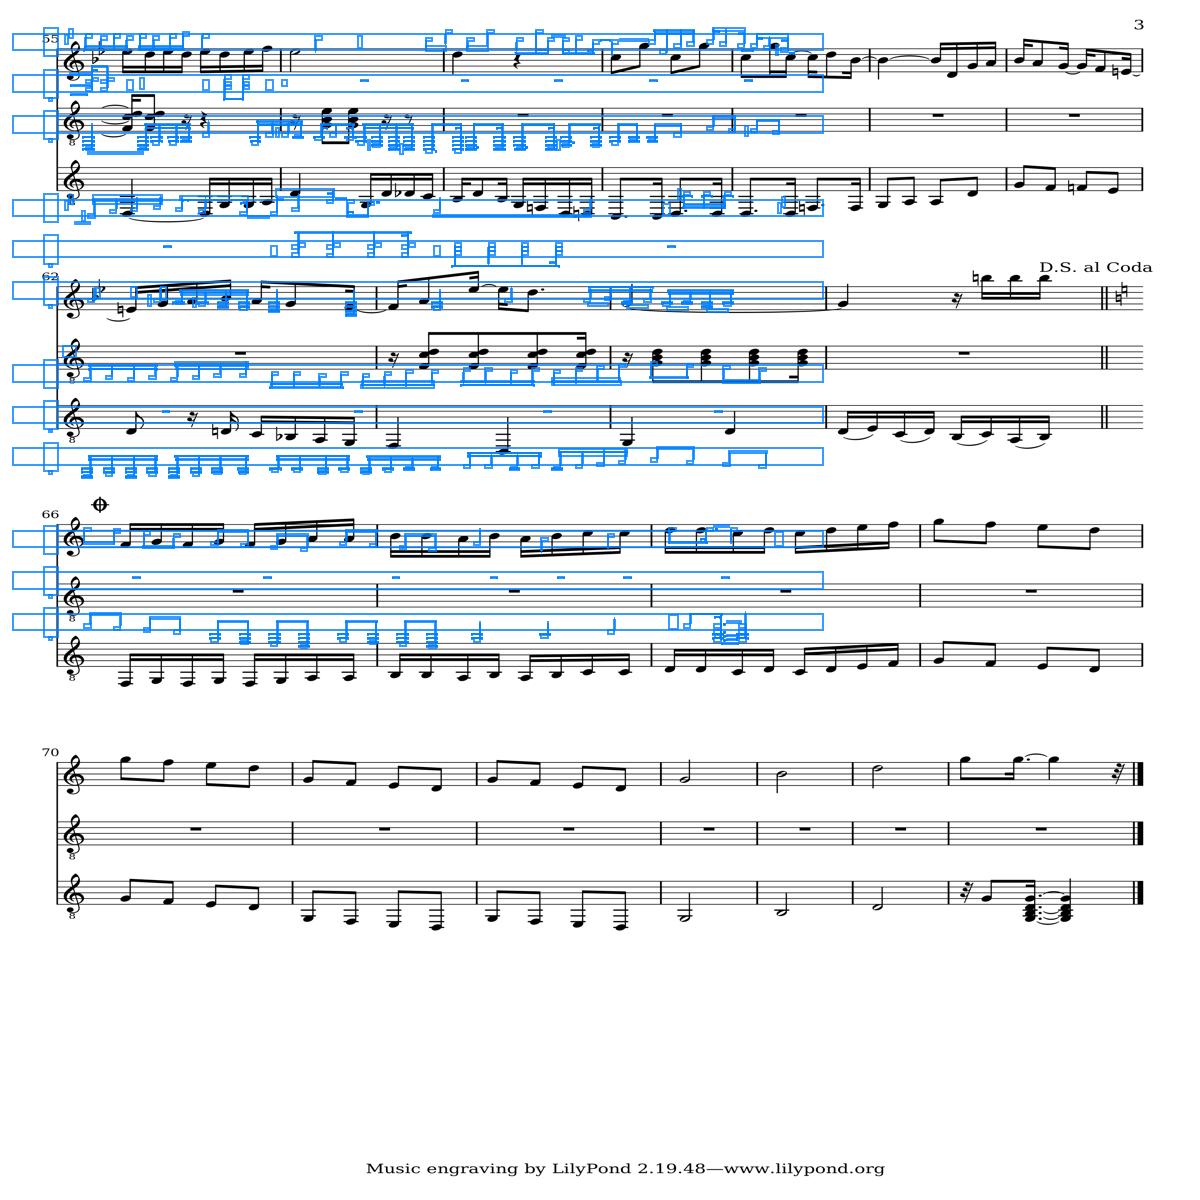

In [63]:
render_gt(gt_df, img_id=679)                     # green boxes, 896×896
render_gt(gt_df, img_id=679, size=1200,          # bigger preview
          colour=(0, 128, 255, 200))

## Predictions

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [ ]:
model = m.YOLOv2Heavy()
model = util.loadModel("concord050", model, device='cuda')
_ = render_prediction(model, anns, img_id=img_ids[0], score_thresh=0.5)


c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\util.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location=device))


[loadMode] Loaded weights from model_dumps\concorde050.pth
[render_prediction] saved → c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\evaluation\679_viz.png


In [3]:
import pandas as pd
import util
gt_df = util.DataExtractor().croppedData()

Saving to: c:\Users\alexh\Desktop\cv2\obb_anns_hausarbeit\ds2_dense\ds2_dense\gt_space.json


In [4]:
gt_df.head()

,img_id,crop_id,cx_loc,cy_loc,tx,ty,tw,th,class_id,filename,cx,cy,crop_row,crop_col
0,679,2,8,5,0.000000,0.617912,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,56,5,0,2
1,679,2,8,11,0.000000,0.154405,3.772461,0.249753,134,lg-877777775968732096-aug-gonville--page-3.png,56,11,0,2
2,679,3,15,18,0.328671,0.319279,-0.489309,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,87,18,0,3
3,679,3,15,18,0.397779,0.856644,-0.591092,-3.261793,1,lg-877777775968732096-aug-gonville--page-3.png,87,18,0,3
4,679,3,12,18,0.863842,0.319279,-0.522099,-2.856328,1,lg-877777775968732096-aug-gonville--page-3.png,84,18,0,3


In [57]:
max pixel error centre  = 0.0000 px, 0.0000 px

SyntaxError: invalid syntax (3518856441.py, line 1)

In [58]:
import numpy as np

# pick 1 000 random rows from your final dataframe
ann = gt_df.sample(1000, random_state=0)

# load one image to get its size (all images in the sample can be different)
# we’ll handle that per-row
from PIL import Image
import os

def pixel_error(row):
    # read image size for THIS row
    w, h = Image.open(
        os.path.join(config.img_dir, row.filename)
    ).size

    # decode centre from (cx, tx) / (cy, ty)
    x_dec = (row.cx + row.tx) / config.S
    y_dec = (row.cy + row.ty) / config.S

    # true centre from a_bbox (only need to compute once)
    x1, y1, x2, y2 = row.a_bbox            # ← field still in anns_df
    x_true = ((x1 + x2) * 0.5) / w
    y_true = ((y1 + y2) * 0.5) / h

    return abs(x_true - x_dec) * w, abs(y_true - y_dec) * h  # pixel error

# compute max pixel error over the sample
err_x_px, err_y_px = np.array(list(ann.apply(pixel_error, axis=1))).max(axis=0)
print(f"max pixel error centre = {err_x_px:.4f} px, {err_y_px:.4f} px")


AttributeError: 'Series' object has no attribute 'a_bbox'

In [ ]:
from PIL import Image, ImageDraw
import numpy as np, os, pandas as pd, math

def renderCrop(cropped_df: pd.DataFrame,
               img_id:   int,
               crop_id:  int,
               *,
               shift_cells: int = 0,          # ← NEW: −1 left, +1 right
               color=(0, 255, 0, 200),
               out_dir="evaluation/crops",
               out_size=896):
    """
    Visualise one N×N crop with its GT boxes.

    Parameters
    ----------
    cropped_df  : DataFrame from DataExtractor.croppedData(grouped=False)
    img_id      : image identifier
    crop_id     : flat crop index (same as in dataframe)
    shift_cells : integer; offset all boxes horizontally by this many cells
                  (<0 = left, >0 = right, 0 = no shift)
    color       : RGBA outline colour
    out_dir     : directory for saved PNG
    out_size    : output square resolution; None keeps native crop size
    """
    # ------------------ rows that belong to (img_id, crop_id)
    rows = cropped_df[(cropped_df.img_id == img_id) &
                      (cropped_df.crop_id == crop_id)]
    if rows.empty:
        raise ValueError(f"No rows for img_id={img_id}, crop_id={crop_id}")

    # ------------------ load full image
    img_path = os.path.join(config.img_dir, rows.filename.iloc[0])
    img = Image.open(img_path).convert("RGB")
    W, H = img.size

    # ------------------ crop geometry (exact)
    S, N  = config.S, config.N
    m     = S // N                           # cells per crop edge
    cell_w, cell_h = W / S, H / S            # fractionals allowed

    crop_row = int(rows.crop_row.iloc[0]) 
    crop_col = int(rows.crop_col.iloc[0]) 

    x0 = crop_col * m * cell_w
    y0 = crop_row * m * cell_h
    x1 = x0 + m * cell_w
    y1 = y0 + m * cell_h

    crop = img.crop((int(round(x0)), int(round(y0)),
                     int(round(x1)), int(round(y1))))
    crop_w, crop_h = crop.size

    # ------------------ optional upscale
    scale = out_size / crop_w if out_size else 1.0
    if out_size:
        crop = crop.resize((out_size, out_size), Image.BILINEAR)

    draw = ImageDraw.Draw(crop, "RGBA")

    # ------------------ anchor (full-image relative)
    aw, ah = config.ANCHORS[0]

    # ------------------ draw each GT box
    for _, r in rows.iterrows():
        # centre *inside the crop*, 0‒crop_w / 0‒crop_h
        xc_px = ((r.cx_loc + r.tx) / m) * crop_w
        
        yc_px = ((r.cy_loc + r.ty) / m) * crop_h

        # -------- optional horizontal shift (fun offset) ----------
        xc_px += shift_cells * (crop_w / m)

        # width & height in pixels
        w_px = math.exp(r.tw) * aw * W
        h_px = math.exp(r.th) * ah * H

        # upscale
        xc_px *= scale
        yc_px *= scale
        w_px  *= scale
        h_px  *= scale

        # rectangle corners
        x1b = xc_px - w_px / 2
        y1b = yc_px - h_px / 2
        x2b = xc_px + w_px / 2
        y2b = yc_px + h_px / 2

        draw.rectangle([x1b, y1b, x2b, y2b], outline=color, width=2)

    # ------------------ save & return
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_{crop_id}_viz.png")
    crop.save(out_path)
    print(f"[renderCrop] saved → {out_path}")
    return crop


[renderCrop] saved → evaluation/crops\1029_0_viz.png


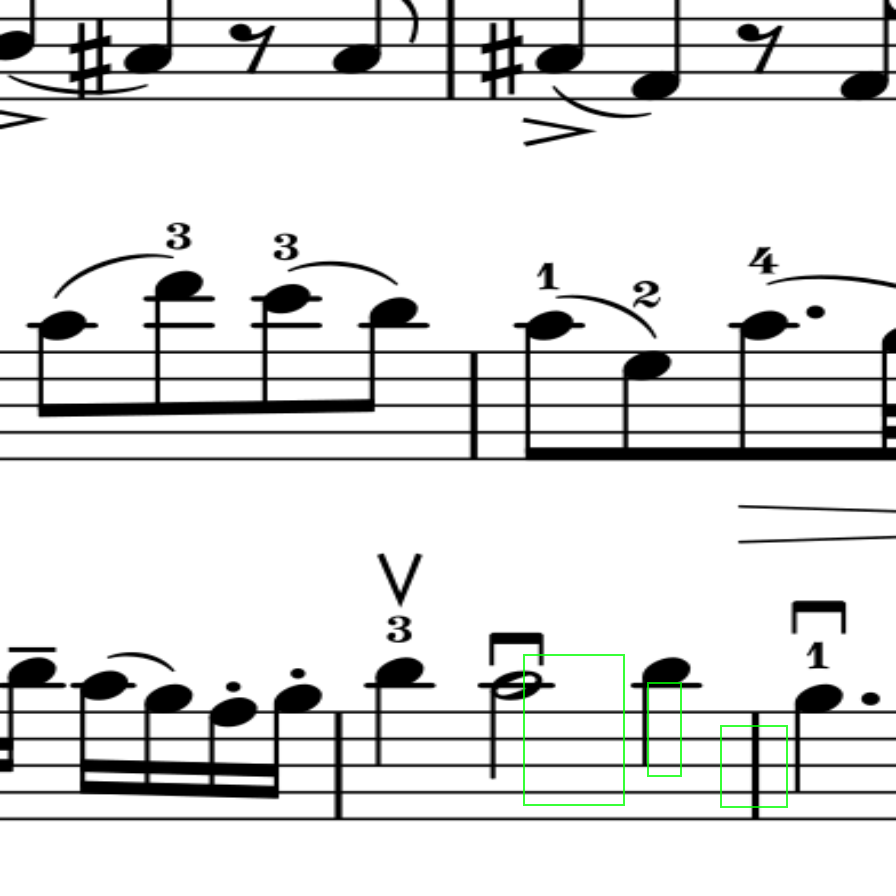

In [54]:
import os
import config
from PIL import Image, ImageDraw
import numpy as np
renderCrop(cropped_df = gt_df, img_id = 1029, crop_id = 0)

In [59]:
from PIL import Image, ImageDraw
import math, os, pandas as pd

def renderFullImage(gt_df: pd.DataFrame,
                    img_id: int,
                    *,
                    color=(0, 255, 0, 200),   # outline RGBA
                    out_dir="evaluation/full",
                    out_size=None):          # e.g. 1200 for quick viewing
    """
    Draw every GT box for one page and save the visualised image.

    Parameters
    ----------
    gt_df    : dataframe (either normalised or cropped – must contain
               filename, cx, cy, tx, ty, tw, th)
    img_id   : which page to render
    color    : rectangle outline colour
    out_dir  : where to save the PNG
    out_size : optional long-edge resize for convenience (int)

    Returns
    -------
    PIL.Image.Image  (the rendered full page)
    """
    rows = gt_df[gt_df.img_id == img_id]
    if rows.empty:
        raise ValueError(f"No rows with img_id={img_id}")

    # --------------- open the page once
    img_path = os.path.join(config.img_dir, rows.filename.iloc[0])
    img = Image.open(img_path).convert("RGB")
    W, H = img.size
    draw = ImageDraw.Draw(img, "RGBA")

    # --------------- constants
    S        = config.S
    aw, ah   = config.ANCHORS[0]          # relative anchor size (w, h)

    # --------------- draw every GT box
    for _, r in rows.iterrows():
        # centre in image-relative units
        x_rel = (r.cx + r.tx) / S
        y_rel = (r.cy + r.ty) / S

        # width / height
        w_rel = math.exp(r.tw) * aw
        h_rel = math.exp(r.th) * ah

        xc = x_rel * W
        yc = y_rel * H
        w  = w_rel * W
        h  = h_rel * H

        x1 = xc - w / 2
        y1 = yc - h / 2
        x2 = xc + w / 2
        y2 = yc + h / 2

        draw.rectangle([x1, y1, x2, y2], outline=color, width=2)

    # --------------- optional down/up-scale for easier viewing
    if out_size:
        long_side = max(W, H)
        scale     = out_size / long_side
        new_w     = int(round(W * scale))
        new_h     = int(round(H * scale))
        img       = img.resize((new_w, new_h), Image.BILINEAR)

    # --------------- save & return
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{img_id}_full_gt.png")
    img.save(out_path)
    print(f"[renderFullImage] saved → {out_path}")
    return img


[renderFullImage] saved → evaluation/full\679_full_gt.png


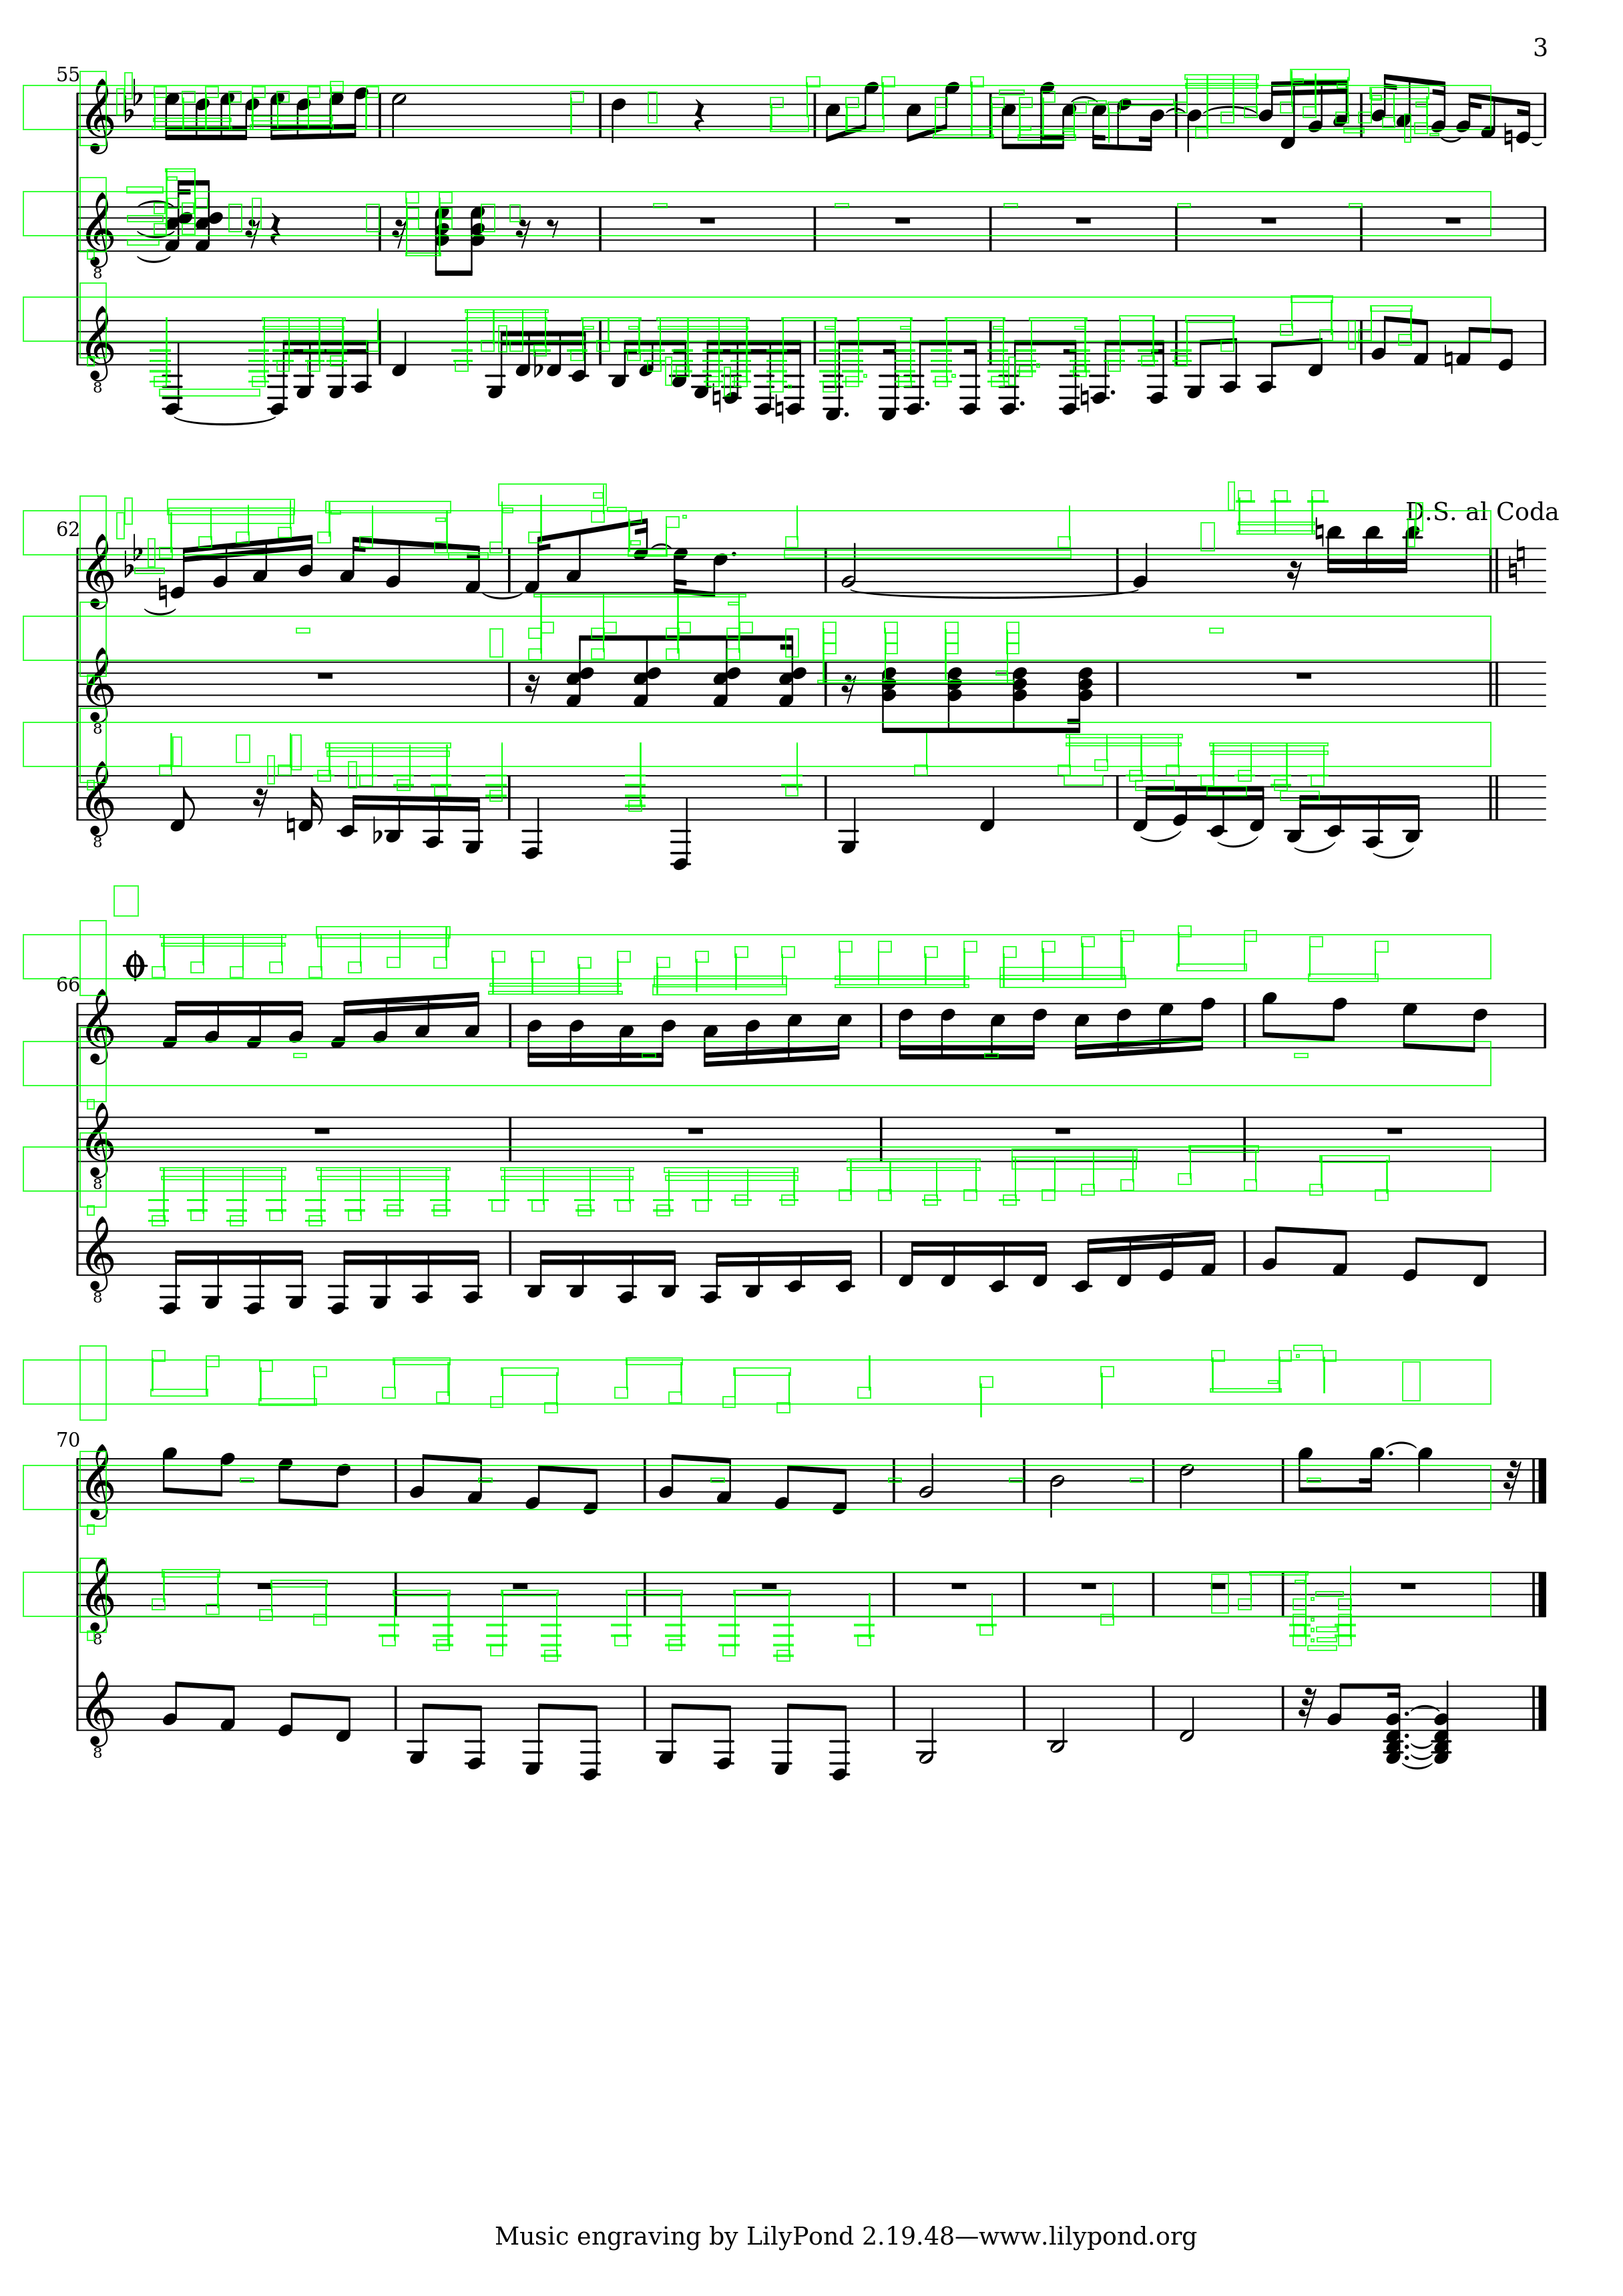

In [61]:
renderFullImage(gt_df, 679)  